In [1]:
import sys
sys.path += ['../']
import pandas as pd
from src.utils import *

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/pataki/.conda/envs/fastai/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['partition', 'uniform', 'array', 'subplots', 'copy', 'pad', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
meta = pd.read_csv('/home/pataki/mosquito/data/meta_all_raw.csv')
print(meta.shape)
meta.head()

(7686, 13)


,imgNmb,imgId,rprtId,imgDate,imgTime,imgLon,imgLat,imgClass,imgLabel,hidden,year,file,isTiger
0,2014_000091.png,f2a43106-6ca7-4dc0-a576-3526101ad1e7,56dfd08a-a2f3-42b3-b0ad-dcf89dfce164,2014-06-18,18:13:54,2.7925459999999998,41.970585,Ae.albopictus,probable,False,2014,/home/pataki/dummy_mosquito/mosquitoAlert-mast...,1
1,2014_000099.png,f67df72f-e181-486d-b3b3-140a4f8d27f8,7fe6dc17-5858-4800-a864-4838f8a427c5,2014-06-21,19:53:58,-0.834205,37.759853,Ae.albopictus,probable,False,2014,/home/pataki/dummy_mosquito/mosquitoAlert-mast...,1
2,2014_000105.png,5e6952dc-09e6-4468-9f96-441660b1a45f,e727b596-f443-45ce-bc64-d392893ad746,2014-06-23,04:51:45,2.253791,41.45605,Ae.albopictus,confirmed,False,2014,/home/pataki/dummy_mosquito/mosquitoAlert-mast...,1
3,2014_000119.png,1d4a81e7-f1c1-45e1-aa75-d15ca04e20f6,33c47455-74c4-492f-9775-c722c668dd97,2014-06-23,20:18:04,0.48081899999999994,40.48278,Ae.albopictus,probable,False,2014,/home/pataki/dummy_mosquito/mosquitoAlert-mast...,1
4,2014_000144.png,aa7137aa-2d41-4243-8ed9-6e6797babe18,2d9999e2-a1ec-4410-bab8-b1461de2c13e,2014-06-27,17:01:12,2.114958,41.381565,Ae.albopictus,probable,False,2014,/home/pataki/dummy_mosquito/mosquitoAlert-mast...,1


In [3]:
Counter(meta.year)

Counter({2014: 92, 2015: 2294, 2016: 1177, 2017: 1209, 2018: 1636, 2019: 1278})

In [4]:
tmp = meta.groupby('rprtId').count().reset_index()
unique_reports = tmp[tmp.imgNmb == 1].rprtId.values
test_data  = meta[(meta.rprtId.isin(unique_reports)) & (meta.year == 2019)].head(1000)
train_data = meta[~meta.imgNmb.isin(test_data.imgNmb.values)] 

len(test_data), len(train_data)

(1000, 6686)

In [5]:
Counter(test_data.isTiger), Counter(train_data.isTiger)

(Counter({0: 291, 1: 709}), Counter({1: 5486, 0: 1200}))

In [6]:
np.random.seed(42)

pred_dict = {}
label_dict = {}
for f in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        
    preds, labels = train_predict(df_train = train_data.sample(frac = f)[['file', 'isTiger']], 
                                  df_test = test_data[['file', 'isTiger']], 
                                  path='/')
        
    pred_dict[f]  = preds
    label_dict[f] = labels

epoch,train_loss,valid_loss,error_rate,AUROC,time
0,1.194466,0.843743,0.288000,0.762450,00:13
1,0.987919,0.766782,0.252000,0.780020,00:11
2,0.738152,0.542506,0.195000,0.830340,00:11
3,0.562749,0.503001,0.184000,0.835720,00:11
4,0.458022,0.495418,0.183000,0.837242,00:11


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.267384,0.495246,0.189000,0.838081,00:13
1,0.244186,0.457963,0.188000,0.867971,00:12
2,0.208413,0.436013,0.158000,0.867448,00:12
3,0.177441,0.442070,0.151000,0.872174,00:12
4,0.155064,0.424894,0.149000,0.874893,00:12


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,1.134687,0.881071,0.275000,0.794386,00:23
1,0.764751,0.571310,0.196000,0.811947,00:17
2,0.506932,0.484195,0.175000,0.850004,00:17
3,0.374505,0.453628,0.159000,0.874699,00:17
4,0.281379,0.424598,0.153000,0.884005,00:16


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.216218,0.403864,0.140000,0.893539,00:20
1,0.220770,0.527309,0.171000,0.868728,00:20
2,0.197794,0.386673,0.139000,0.912393,00:20
3,0.145184,0.378462,0.133000,0.914831,00:20
4,0.116105,0.362712,0.138000,0.914908,00:20


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,1.128769,0.765969,0.243000,0.785926,00:31
1,0.676340,0.518692,0.171000,0.838081,00:22
2,0.448875,0.421276,0.147000,0.884737,00:22
3,0.334369,0.373733,0.141000,0.903526,00:22
4,0.255994,0.360693,0.141000,0.907924,00:22


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.228069,0.364219,0.138000,0.904512,00:27
1,0.202875,0.342387,0.123000,0.924549,00:27
2,0.176570,0.390813,0.151000,0.910381,00:27
3,0.140082,0.344042,0.122000,0.927190,00:27
4,0.104349,0.360024,0.125000,0.927617,00:28


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.883467,0.672623,0.224000,0.825431,00:33
1,0.524625,0.417895,0.158000,0.882742,00:28
2,0.323686,0.413990,0.143000,0.898681,00:28
3,0.258340,0.368131,0.134000,0.916498,00:28
4,0.225529,0.376257,0.142000,0.919242,00:28


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.204375,0.355011,0.133000,0.926347,00:35
1,0.205700,0.373874,0.118000,0.918185,00:35
2,0.157519,0.317476,0.112000,0.934921,00:35
3,0.112406,0.292789,0.099000,0.938139,00:35
4,0.089461,0.311024,0.101000,0.938736,00:35


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.799818,0.719177,0.250000,0.769503,00:35
1,0.432556,0.408258,0.158000,0.885726,00:34
2,0.309901,0.409936,0.149000,0.887611,00:34
3,0.268450,0.398583,0.143000,0.897028,00:34
4,0.217630,0.373172,0.136000,0.911540,00:34


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.202868,0.341204,0.127000,0.917356,00:42
1,0.192404,0.422585,0.147000,0.912412,00:42
2,0.146289,0.301319,0.113000,0.939666,00:42
3,0.108142,0.284554,0.095000,0.946151,00:43
4,0.080275,0.282846,0.096000,0.947339,00:42


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.805284,0.539561,0.200000,0.828993,00:40
1,0.413368,0.416708,0.157000,0.881431,00:40
2,0.307793,0.417486,0.155000,0.891813,00:39
3,0.248554,0.346879,0.134000,0.919983,00:39
4,0.205853,0.337575,0.124000,0.926323,00:40


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.208703,0.299806,0.108000,0.939225,00:50
1,0.199944,0.299368,0.112000,0.934180,00:50
2,0.143807,0.286809,0.099000,0.942124,00:50
3,0.102572,0.249024,0.092000,0.957808,00:50
4,0.086418,0.260886,0.095000,0.954934,00:50


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.689499,0.549595,0.191000,0.823763,00:45
1,0.360637,0.402942,0.145000,0.888338,00:45
2,0.285279,0.343463,0.130000,0.925184,00:45
3,0.231364,0.319227,0.115000,0.934684,00:45
4,0.185233,0.309342,0.117000,0.941552,00:45


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.175086,0.336539,0.121000,0.934332,00:58
1,0.181792,0.282419,0.093000,0.947877,00:57
2,0.141673,0.305916,0.110000,0.952317,00:57
3,0.095452,0.260431,0.097000,0.959669,00:57
4,0.074600,0.252253,0.091000,0.957672,00:57


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.708043,0.545632,0.192000,0.851676,00:51
1,0.380095,0.382516,0.152000,0.895918,00:51
2,0.287162,0.324358,0.124000,0.923836,00:51
3,0.254198,0.289420,0.112000,0.935469,00:51
4,0.201557,0.295115,0.110000,0.936671,00:51


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.203874,0.247641,0.093000,0.955494,01:05
1,0.191497,0.289428,0.113000,0.945722,01:05
2,0.136128,0.273753,0.100000,0.959626,01:05
3,0.082088,0.228764,0.097000,0.967046,01:05
4,0.072955,0.209419,0.084000,0.968423,01:05


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.648756,0.517835,0.175000,0.841963,00:57
1,0.353499,0.419425,0.146000,0.893660,00:57
2,0.253496,0.335518,0.126000,0.922756,00:57
3,0.223213,0.321727,0.121000,0.935130,00:57
4,0.193731,0.306585,0.119000,0.940665,00:57


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.199991,0.306354,0.128000,0.941411,01:12
1,0.203628,0.266853,0.101000,0.955491,01:12
2,0.141067,0.242881,0.094000,0.962674,01:13
3,0.093568,0.222889,0.081000,0.961172,01:13
4,0.079476,0.218745,0.082000,0.964884,01:13


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.587715,0.523769,0.197000,0.867831,01:02
1,0.320704,0.421118,0.149000,0.904323,01:02
2,0.268213,0.356171,0.125000,0.926633,01:02
3,0.235773,0.300918,0.110000,0.939841,01:02
4,0.189993,0.268635,0.105000,0.948243,01:02


epoch,train_loss,valid_loss,error_rate,AUROC,time
0,0.197854,0.285966,0.104000,0.943679,01:20
1,0.184504,0.280008,0.102000,0.958777,01:20
2,0.140384,0.217411,0.080000,0.964768,01:20
3,0.082309,0.211268,0.080000,0.967545,01:20
4,0.071630,0.204736,0.072000,0.968093,01:20


In [7]:
%%time
np.random.seed(42)
meanAUC = []
stdAUC = []

meanACC = []
stdACC  = []
for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    labels = label_dict[i]
    preds  = pred_dict[i]
    
    AUC = []
    ACC = []
    for k in range(500):
        idxs = np.random.choice(range(len(labels)), len(labels))
        auc = roc_auc_score(y_true = np.array(labels)[idxs] , y_score = np.array(preds)[idxs][:,1])
        AUC.append(auc)
        ACC.append((np.array(labels)[idxs] == (np.array(preds)[idxs][:,1] > 0.5)).mean())
        
    meanAUC.append(np.mean(AUC))
    stdAUC.append(np.std(AUC))
    
    meanACC.append(np.mean(ACC))
    stdACC.append(np.std(ACC))

CPU times: user 10.6 s, sys: 48 ms, total: 10.6 s
Wall time: 9.75 s


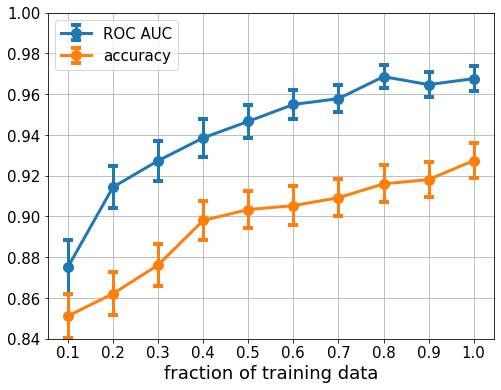

In [8]:
plt.figure(figsize=(8, 6))
plt.errorbar(np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), #*len(train),
             meanAUC, stdAUC, marker='o', ms=10, lw=3, capsize=5, capthick=4, label='ROC AUC')

plt.errorbar(np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), #*len(train),
             meanACC, stdACC, marker='o', ms=10, lw=3, capsize=5, capthick=4, label='accuracy')
plt.xlabel('fraction of training data', fontsize=18)
plt.ylim(0.84, 1.00)
plt.legend(fontsize=15)
plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
           [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize=15)
plt.yticks(fontsize=15)
plt.grid()

In [9]:
Counter(test_data.isTiger)

Counter({False: 291, True: 709})